# Example script for i3 files

This is intended to be a short example for how to loop over 
an icecube i3 file with icetray's python interface. Here, I'll
be looping through a single file to get the times for each hit
in the simulation file as well as a flag for each hit to tell
us whether each hit is from noise or some interesting physics
interaction.

This is intended as an example only. Feel free to made edits 
or work in this notebook if needed. If you get lost and need
to work with some object you're not familiar with, remember
that jupyter supports tab completion. If, for example, you're
looking at an `I3RecoPulse` called `pulse`, you can do `pulse.[tab]`
and see a list of possible functions and attributes.

You can also use tab completion if you can't remember a function.
Using `np.his[tab]` will show you all possible functions in numpy
that being with the letters `his`, allowing you to find `hist2d`.

If you have a function you don't know, you can ask jupyter for
more information. For example, if you want to better understand
the `numpy.save` function, run `np.save?` in a new cell to see
the documentation.

Don't be afraid to ask questions. Using new software is always
difficult and you shouldn't worry about feeling lost. Not asking
will just waste your time and no one will judge you for not knowing
something. 

In [4]:
import numpy as np
import time
import glob
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from icecube.dataio import I3File
from icecube.icetray import I3Frame, I3Units
from icecube.dataclasses import I3RecoPulse

## Pick the files you want to run
Here I'll use a single file. You're going to want to use your own
choice of input file, so this will be something to you need to change.

Don't know what the path is to your file? In your terminal, find your 
file using `cd` and `ls`. Once you find what you want, type `echo $PWD/filename_that_you_want` to get the full path here. Copy that and
paste it here inside of quotes.

Later, you'll want to be able to loop over multiple files. For that,
you'll want to use python's `glob.glob` function. There's documentation
online if you use google, but the short version is (note the asterisk)

> import glob
> filelist = glob.glob("/home/icecube/icetray/data/gen2/NuMu*")

 will give you a list of files from `/home/icecube/icetray/data/gen2/` 
that start with `NuMu`. Keep this in mind for later when you want to 
get more events.

In [127]:
filename = "/i3store/users/gen2/22450/0000000-0000999/NuGen_NuMu_Gen2_LOM16_240m_6.i3.zst"

## Example looping
I'll loop over a single file here and pull out some information
from the events. We'll be looking at `I3RecoPulse` objects here.

This is the structure for running over a single file. Once you try
to run over multiple types of files (like, say, files that have
noise only vs noise+physics hits!), you'll want to generalize this
by wrapping the whole thing in a function that you can pass a 
filename in and get lists (or arrays) back out. That way you won't
need to have multiple copies of the same code, which becomes a bit
of a pain to keep track of when changing code (and can cause problems
that are hard to diagnose!). 

In [37]:
def get_data(glob_thing, count):
    frame_number = 0
    event = []
    energy=[]
    string = []
    module = []
    pmt = []
    times = []

    #---------------------------------------
    # Open the file
    #---------------------------------------
    for filename in glob_thing:
        i3file = I3File(filename)
        for frame in i3file:
            if frame.Stop != I3Frame.DAQ: continue
            
            # if frame_number>500:
            #     continue
            if (frame_number%count)==0:
                print(frame_number)
        
            frame_number += 1

            #---------------------------------------
            # Get the hits out from the i3 file
            #---------------------------------------
            pulses_map = frame['I3RecoPulseSeriesMapGen2']
    
            #---------------------------------------
            # And now pull information out to our
            # output lists
            #---------------------------------------
            
            #energy_number=frame['I3MCWeightDict']['PrimaryNeutrinoEnergy']
            
            for pmtkey, pulse_list in pulses_map:
                for pulse in pulse_list:
                    #---------------------------------------
                    # Store which event we're looking at over and over again so we know which pulses correlate to which events...this will take 1500 years
                    #---------------------------------------
                    
                    #energy.append(energy_number)
                    event.append(frame_number)
                    string.append(pmtkey.string)
                    module.append(pmtkey.om)
                    pmt.append(pmtkey.pmt)
            
                    # Times are special: they're measured relative to the particle interaction. In order to make
                    # sure we don't have overlaps in our times, we'll shift the actual times we're writing out based
                    # on the event number.
                    times.append(pulse.time + frame_number*1e6)
            
    #---------------------------------------
    # Let's convert these to numpy arrays even though I'm gonna smush them into one numpy array later to make it easier to index things because
    # I think maybe when I smush it it keeps the dtype=int from here which would make it faster instead of making everything a float, but it might be a waste of code:).
    #---------------------------------------
    #energy=np.array(energy, dtype=float)
    event = np.array(event, dtype=int)
    string = np.array(string, dtype=int)
    module = np.array(module, dtype=int)
    pmt = np.array(pmt, dtype=int)
    times = np.array(times, dtype=float)

    length=len(string)    
    arr=np.dstack((event, string, module, pmt, times))
    return arr, length


In [217]:
physics_glob=glob.glob('/i3store/users/gen2/22450/0000000-0000999/NuGen*')
physics_array, physics_length=get_data(physics_glob, 1000)
print("Length of physics array=" + str(physics_length))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Length of physics array=83798215


In [1013]:
noise_glob=glob.glob('/i3store/users/gen2/22449/0000000-0000999/RandomNoise*')
noise_array, noise_length=get_data(noise_glob, 1)
print("Length of noise array=" + str(noise_length))

1
2
3
4
5
6
7
8
9
10
Length of noise array=81410615


In [1047]:
shape_noise=np.shape(noise_array)
new_shape_noise=np.delete(shape_noise,0)
better_event_noise=np.reshape(noise_array,new_shape_noise)
#better_event_noise=np.delete(better_event_noise, 3, axis=1)
print(better_event_noise)

[[1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  1.38686509e+06]
 [1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  7.62587787e+06]
 [1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  7.62923905e+06]
 ...
 [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.49183417e+07]
 [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.58993431e+07]
 [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.59011561e+07]]


In [1015]:
time=[]
first_index=0
last_index=0
previous_event=1
previous_string=1001
previous_dom=1
previous_pmt=0
count=0

for current_index, row in enumerate(better_event_noise):
    count+=1
    if count%5000000==0:
            print(count)
    
    if  previous_dom!=row[2] or previous_string!=row[1] or previous_event!=row[0]:  #now on a new dom, so sort the last list and replace it for last DOM
        last_index=current_index
        time.sort()
        better_event_noise[first_index:last_index,3]=time
        
        time=[]
        first_index=current_index

        previous_dom=row[2]
        previous_string=row[1]
        previous_event=row[0]
    
    time.append(row[3])
    

5000000
10000000
15000000
20000000
25000000
30000000
35000000
40000000
45000000
50000000
55000000
60000000
65000000
70000000
75000000
80000000


In [1068]:
noise_timing_array=timing(better_event_noise)

5000000
10000000
15000000
20000000
25000000
30000000
35000000
40000000
45000000
50000000
55000000
60000000
65000000
70000000
75000000
80000000


In [1194]:
physics_glob=glob.glob('/i3store/users/gen2/22450/0000000-0000999/NuGen*')
physics_array, physics_length=get_data(physics_glob, 1000)
print("Length of physics array=" + str(physics_length))

0


KeyboardInterrupt: 

In [1065]:
shape_phys=np.shape(physics_array)
new_shape_phys=np.delete(shape_phys,0)
better_event_phys=np.reshape(physics_array,new_shape_phys)
print(better_event_phys)

[[1.00000000e+00 1.00100000e+03 3.00000000e+00 3.00000000e+00
  1.01283235e+06]
 [1.00000000e+00 1.00100000e+03 5.00000000e+00 1.30000000e+01
  1.02503579e+06]
 [1.00000000e+00 1.00100000e+03 8.00000000e+00 0.00000000e+00
  1.00206232e+06]
 ...
 [2.53160000e+04 1.12000000e+03 4.40000000e+01 6.00000000e+00
  2.53160082e+10]
 [2.53160000e+04 1.12000000e+03 4.40000000e+01 6.00000000e+00
  2.53160119e+10]
 [2.53160000e+04 1.12000000e+03 7.50000000e+01 8.00000000e+00
  2.53160216e+10]]


In [1056]:
time=[]
first_index=0
last_index=0
previous_event=1
previous_string=1001
previous_dom=3
previous_pmt=3
count=0

for current_index, row in enumerate(better_event_phys):
    count+=1
    if count%5000000==0:
            print(count)
    
    if  previous_dom!=row[2] or previous_string!=row[1] or previous_event!=row[0]:  #now on a new pmt, so sort the last list and replace it for last DOM
        last_index=current_index
        time.sort()
        better_event_phys[first_index:last_index,3]=time
        
        time=[]
        first_index=current_index
        
        previous_pmt=row[3]
        previous_dom=row[2]
        previous_string=row[1]
        previous_event=row[0]
    
    time.append(row[3])
    
    

5000000
10000000
15000000
20000000
25000000
30000000
35000000
40000000
45000000
50000000
55000000
60000000
65000000
70000000
75000000
80000000


In [1067]:
phys_timing_array=timing(better_event_phys)

5000000
10000000
15000000
20000000
25000000
30000000
35000000
40000000
45000000
50000000
55000000
60000000
65000000
70000000
75000000
80000000


In [1066]:
def timing(array):
    timing=[]
    prev_event=None
    prev_str=None
    prev_mod=None
    prev_pmt=None
    count=0
    for row in array:
        count+=1
        if count%5000000==0:
            print(count)
        
        if (row[0]==prev_event and row[1]==prev_str and row[2]==prev_mod and row[3]==prev_pmt): #if it is on the same DOM
            time_difference=row[4]-last_time
            timing.append(time_difference)
        else:
            prev_event=row[0]
            prev_str=row[1]
            prev_mod=row[2]
            prev_pmt=row[3]
        
        last_time=row[4]
    return timing

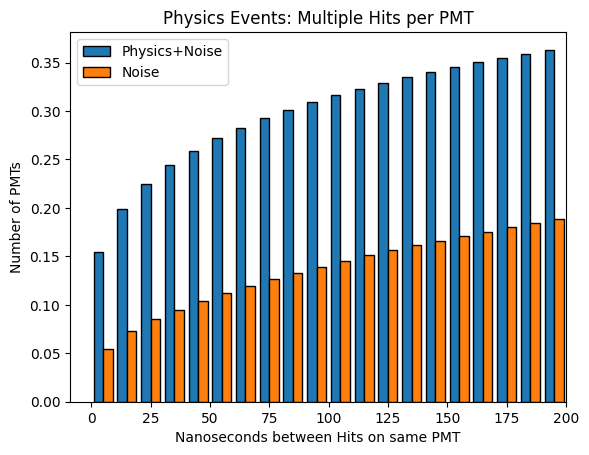

In [1079]:
weight1=np.ones(len(phys_timing_array))/len(better_event_phys)
weight2=np.ones(len(noise_timing_array))/len(better_event_noise)
bins=range(0,201,10)
counts_pmt, bin_pmt, patches_pmt=plt.hist([phys_timing_array, noise_timing_array], bins=bins, edgecolor='black', label=["Physics+Noise", "Noise"],
         weights=[weight1, weight2], cumulative=True)
plt.title("Physics Events: Multiple Hits per PMT")
plt.xlabel("Nanoseconds between Hits on same PMT")
plt.ylabel("Number of PMTs")
plt.legend()
plt.ylim(bottom=0)
plt.xlim(right=200)

plt.savefig("physics_PMT_timings.png")

plt.show()

In [1080]:
y_physics=np.append(counts_pmt[0],0)
x_noise=np.append(counts_pmt[1],0)

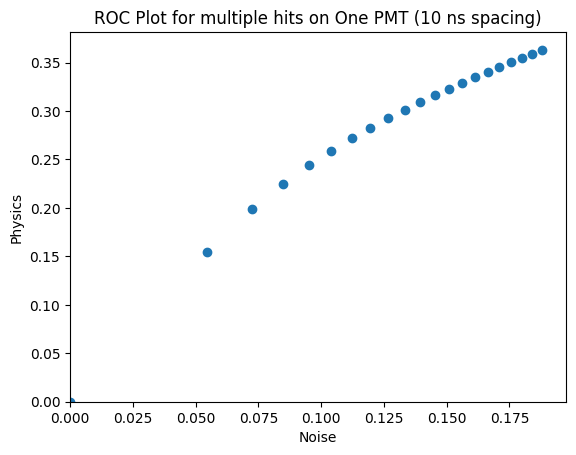

In [1081]:
plt.scatter(x_noise,y_physics)
plt.xlabel("Noise")
plt.ylabel("Physics")
plt.title("ROC Plot for multiple hits on One PMT (10 ns spacing)")
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.savefig("multiple_hit_ROC_plot_2.png")
plt.show()

## Everything above this was kinda BS
So here's the actual stuff used to determine how many PMTs should get hit before we start counting it

I got arrays both with and without the energies included

In [1195]:
physics_file = glob.glob("/i3store/users/gen2/22450/0000000-0000999/NuGen_NuMu_Gen2_LOM16_240m_0.i3.zst")
mult_pmt_physics_event, length_physics =get_data(physics_file, count=100)

0
100
200
300
400
500


In [1418]:
physics_file = glob.glob("/i3store/users/gen2/22450/0000000-0000999/NuGen_NuMu_Gen2_LOM16_240m_0.i3.zst")
energy_pmt_physics_event, length_physics =get_data(physics_file, count=100)

0
100
200
300
400
500


I had to reshape the array because smushing everything together kinda fucked it up

In [23]:
def reshape(array):
    shape=np.shape(array)
    new_shape=np.delete(shape,0)
    reshaped_array=np.reshape(array, new_shape)
    return reshaped_array

In [1421]:
energy_pmt_phys=reshape(energy_pmt_physics_event)
print(energy_pmt_phys)

[[9.97666802e+05 1.00000000e+00 1.00100000e+03 3.00000000e+00
  3.00000000e+00 1.01283235e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 5.00000000e+00
  1.30000000e+01 1.02503579e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.00206232e+06]
 ...
 [4.27263950e+02 5.01000000e+02 6.11200000e+04 1.10000000e+01
  1.20000000e+01 5.01010256e+08]
 [4.27263950e+02 5.01000000e+02 6.11200000e+04 2.50000000e+01
  9.00000000e+00 5.00996467e+08]
 [4.27263950e+02 5.01000000e+02 6.11200000e+04 3.80000000e+01
  1.20000000e+01 5.00997505e+08]]


Set the energy range if there is any.

In [1408]:
def fix_energies(energy_pmt_phys, top_energy, bottom_energy):
    number=[]
    for index, row in enumerate(energy_pmt_phys):
        if row[0]>top_energy or row[0]<bottom_energy:
            number.append(index)
    array=np.delete(energy_pmt_phys, number, axis=0)
    return array

In [ ]:
Tev_10_100_phys_array=fix_energies(energy_pmt_phys, 10000, 1000)

In [1416]:
number_of_hits=len(energy_pmt_phys)
print(number_of_hits)


1680467


Split the numpy array into a list of arrays by string, this can save processing time

In [1422]:
def list_of_arrays_by_string(array, string_column, first_string):
    strings_phys=array[:,string_column].tolist()
    index=[]
    sum_phys=0
    last_string=first_string
    for string in strings_phys:
        if string!=last_string:
            index.append(sum_phys) 
            last_string=string
        sum_phys+=1
    list_of_arrays=np.split(array, index)
    return list_of_arrays

In [1426]:
list_of_phys_arrays=list_of_arrays_by_string(energy_pmt_phys, 2, 1001)

In [1430]:
print(list_of_phys_arrays[0])

[[9.97666802e+05 1.00000000e+00 1.00100000e+03 3.00000000e+00
  3.00000000e+00 1.01283235e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 5.00000000e+00
  1.30000000e+01 1.02503579e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.00206232e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.00253621e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.00277880e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.00554934e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.01014198e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.01079912e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.01754943e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 1.20000000e+01
  3.00000000e+00 1.00278082e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 1.2

In [1431]:
def sort_by_time(list_of_arrays, time_column):
    for index1, array1 in enumerate(list_of_arrays):
        list_of_arrays[index1]=sort_array_time(array1, time_column)

In [1432]:
sort_by_time(list_of_phys_arrays, 5)

In [1441]:
array=list_of_phys_arrays[0]
print(array)

[[9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00084263e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00085808e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00086646e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00088119e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00089026e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00090060e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00091394e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00092917e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00099372e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.20000000e+01
  9.00000000e+00 1.00109404e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 4.2

Now that we've set everything up, we can actually find the distribution

In [ ]:
def hit_distribution(list_of_arrays, nanoseconds):
    list_distribution=[]
    count=0
    
    for array in list_of_arrays:
        #tracking
        count+=1
        if count%10000==0:
            print(count)
            
        #Make other array
        array2=array
        for pulse in array:
            temp=[]
            pmt_count=0
            array2=np.delete(array2, 0, axis=0)
            
            #Loop through until the nanoseconds are exceeded
            i=0
            while i<len(array2) and (array2[i,5]-pulse[5])<nanoseconds:
                #If DOMS are the same and PMTs are different, count it
                if pulse[3]==array2[i,3]:
                    if (pulse[4]!=array2[i,4]) and (array2[i,4] not in temp):
                        pmt_count+=1
                        temp.append(array2[i,4])
                i+=1
            #no in the time window, append the number of pmts that counted
            list_distribution.append(pmt_count)
    return list_distribution

In [1354]:
phys_energy_10_100_pmt_100=hit_distribution(list_of_phys_arrays,100)
phys_energy_10_100_pmt_1000=hit_distribution(list_of_phys_arrays,1000)
phys_energy_10_100_pmt_10000=hit_distribution(list_of_phys_arrays,10000)

10000
10000
10000


In [2]:
def percentage_hit(list_of_arrays, nanoseconds, dom_column, pmt_column, time_column, dom_limit, pmt_hits, total_hits):
    count=0
    hits=[]
    
    for event in list_of_arrays:
        #tracking
        count+=1
        if count%10000==0:
            print(count)
            
        #Make other array
        for string in event:
            string2=string
            for pulse in string:
                temp=[]
                other_pmt_count=0
                #this other array will contain all pulses on the same string after this one
                string2=np.delete(string2, 0, axis=0)
            
                #Loop through until nanoseconds are exceeded
                i=0
                while i<len(array2) and (array2[i,time_column]-pulse[time_column])<nanoseconds:
                    #If DOMS are the same and PMTs are different
                    if pulse[dom_column]==array2[i,dom_column]:
                        if (pulse[pmt_column]!=array2[i,pmt_column]) and (array2[i,pmt_column] not in temp):
                            #count how many "other" pmts are hit
                            other_pmt_count+=1
                            temp.append(array2[i,pmt_column])
                        
                            #if other pmts hit is equal to 2, mark the pulse as a hit and stop going through the while loop
                            if other_pmt_count==pmt_hits:
                                hit+=1
                                break

                    #If DOMS are different but 2 or less away,
                    if abs(pulse[dom_column]-array2[i,dom_column])<=dom_limit and pulse[dom_column]!=array2[i,dom_column]:
                        #count it as a hit, and stop going through the while loop
                        hit+=1
                        break
                    
                    
                    #increment the while loop                
                    i+=1
    return hit/total_hits

In [1507]:
print(number_of_hits)
1678606

1680467


In [1510]:
percent_hit_check_dom=percentage_hit(list_of_phys_arrays, nanoseconds=1000, dom_column=3, pmt_column=4, time_column=5, dom_limit=2, pmt_hits=2, total_hits=number_of_hits)

10000
20000
30000
40000
50000


In [1515]:
print(percent_hit_check_dom)

0.3938119582235176


In [1473]:
physics_percent_hit_2=percentage_hit(list_of_phys_arrays, nanoseconds=1000, dom_column=3, pmt_column=4, time_column=5, dom_limit=2, pmt_hits=2, total_hits=number_of_hits)

10000
20000
30000
40000
50000


In [1474]:
print(physics_percent_hit_2)

0.40018102110901316


In [1480]:
physics_percent_hit_1=percentage_hit(list_of_phys_arrays, nanoseconds=1000, dom_column=3, pmt_column=4, time_column=5, dom_limit=2, pmt_hits=1, total_hits=number_of_hits)
print(physics_percent_hit_1)

10000
20000
30000
40000
50000
0.45867904576525453


In [ ]:
noise_glob=glob.glob("/i3store/users/gen2/22449/0000000-0000999/RandomNoise_Gen2_LOM16_240m_0.i3.zst")
noise_array, noise_length=get_data(noise_glob, 1)
print("Length of noise array=" + str(noise_length))

0
Length of noise array=8092524


In [1462]:
noise_array=reshape(noise_array)
print(noise_array)

[[1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  1.38686509e+06]
 [1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  7.62587787e+06]
 [1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  7.62923905e+06]
 ...
 [1.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  8.67551347e+07]
 [1.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.20034704e+07]
 [1.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.55370445e+07]]


In [1463]:
list_of_noise_arrays=list_of_arrays_by_string(noise_array, 1, 1001)

In [1466]:
print(list_of_noise_arrays[119])

[[1.00000000e+00 1.12000000e+03 1.00000000e+00 0.00000000e+00
  4.79310258e+06]
 [1.00000000e+00 1.12000000e+03 1.00000000e+00 0.00000000e+00
  4.79310768e+06]
 [1.00000000e+00 1.12000000e+03 1.00000000e+00 0.00000000e+00
  4.79315441e+06]
 ...
 [1.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  8.67551347e+07]
 [1.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.20034704e+07]
 [1.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.55370445e+07]]


In [1467]:
sort_by_time(list_of_noise_arrays, 4)

In [1468]:
print(list_of_noise_arrays[119])

[[1.00000000e+00 1.12000000e+03 4.50000000e+01 1.30000000e+01
  8.38904618e+05]
 [1.00000000e+00 1.12000000e+03 1.10000000e+01 8.00000000e+00
  8.40098784e+05]
 [1.00000000e+00 1.12000000e+03 1.10000000e+01 6.00000000e+00
  8.40152697e+05]
 ...
 [1.00000000e+00 1.12000000e+03 4.60000000e+01 6.00000000e+00
  1.00808119e+08]
 [1.00000000e+00 1.12000000e+03 3.00000000e+01 1.00000000e+01
  1.00811838e+08]
 [1.00000000e+00 1.12000000e+03 1.50000000e+01 4.00000000e+00
  1.00827478e+08]]


In [1477]:
noise_percent_hit_2=percentage_hit(list_of_noise_arrays, nanoseconds=1000, dom_column=2, pmt_column=3, time_column=4, dom_limit=2, pmt_hits=2, total_hits=noise_length)
print(noise_percent_hit_2)

10
20
30
40
50
60
70
80
90
100
110
120
0.033040000869938725


In [1506]:
noise_percent_hit_1=percentage_hit(list_of_noise_arrays, nanoseconds=1000, dom_column=2, pmt_column=3, time_column=4, dom_limit=2, pmt_hits=1, total_hits=noise_length)
print(noise_percent_hit_1)

10
20
30
40
50
60
70
80
90
100
110
120
0.12989470281459778


In [1503]:
print(noise_percent_hit_1)

0.12989470281459778


In [1256]:
phys_other_pmt_100=hit_distribution(list_of_phys_arrays,100)
phys_other_pmt_1000=hit_distribution(list_of_phys_arrays,1000)
phys_other_pmt_10000=hit_distribution(list_of_phys_arrays,10000)

10000
20000
30000
40000
50000
10000
20000
30000
40000
50000
10000
20000
30000
40000
50000


In [1327]:
noise_file= glob.glob("/i3store/users/gen2/22449/0000000-0000999/RandomNoise_Gen2_LOM16_240m_0.i3.zst")
energy_noise_event, length_noise=get_data(noise_file, count=5)

0


KeyError: 'I3MCWeightDict'

In [1183]:
#Reshaping, then deleting unnecessary data
shape_noise=np.shape(mult_pmt_noise_event)
new_shape_noise=np.delete(shape_noise,0)
better_noise_event=np.reshape(mult_pmt_noise_event,new_shape_noise)
better_noise_event=np.delete(better_noise_event, 0, axis=1)
print(better_noise_event)

[[1.00100000e+03 1.00000000e+00 0.00000000e+00 1.38686509e+06]
 [1.00100000e+03 1.00000000e+00 0.00000000e+00 7.62587787e+06]
 [1.00100000e+03 1.00000000e+00 0.00000000e+00 7.62923905e+06]
 ...
 [1.12000000e+03 8.00000000e+01 1.40000000e+01 8.67551347e+07]
 [1.12000000e+03 8.00000000e+01 1.40000000e+01 9.20034704e+07]
 [1.12000000e+03 8.00000000e+01 1.40000000e+01 9.55370445e+07]]


In [1184]:
#indexing in order to split by string
strings_noise=better_noise_event[:,0].tolist()
index_noise=[]
sum_noise=0
last_string=None
count=0
for string in strings_noise:
    if count%1000000==0:
        print(count)
    count+=1
    
    if string!=last_string:
        index_noise.append(sum_noise) 
        last_string=string
    sum_noise+=1

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000


In [1185]:
list_of_noise_arrays=np.split(better_noise_event,index_noise)
list_of_noise_arrays.pop(0)

array([], shape=(0, 4), dtype=float64)

In [1186]:
for index1, array1 in enumerate(list_of_noise_arrays):
    list_of_noise_arrays[index1]=sort_array_time(array1, 3)

In [1263]:
noise_pmt_other_100=hit_distribution(list_of_noise_arrays,100)
noise_pmt_other_1000=hit_distribution(list_of_noise_arrays,1000)


10
20
30
40
50
60
70
80
90
100
110
120
10
20
30
40
50
60
70
80
90
100
110
120


NameError: name 'noise_pmt_other_10000' is not defined

In [1264]:
noise_pmt_other_10000=hit_distribution(list_of_noise_arrays,10000)

10
20
30
40
50
60
70
80
90
100
110
120


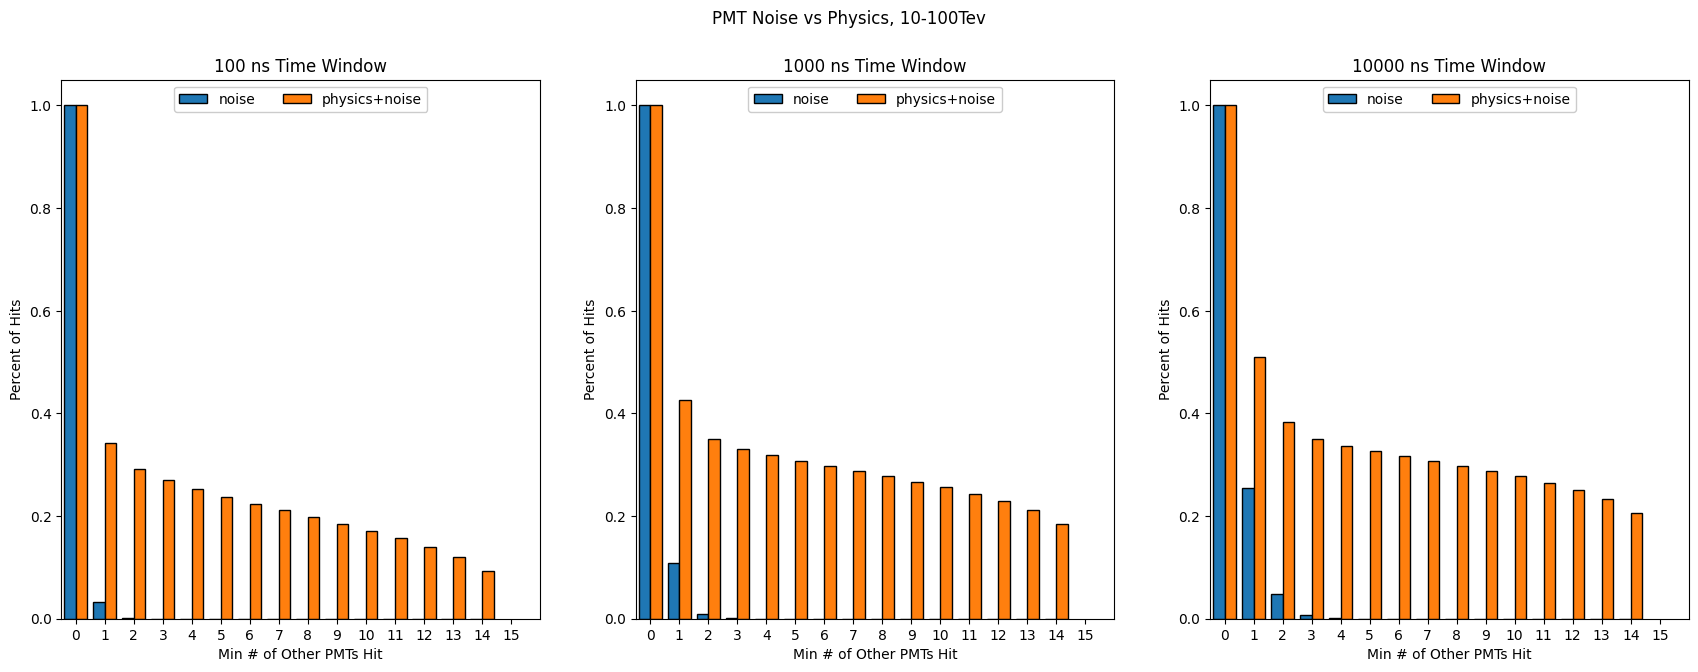

In [1499]:
fig, (ax0, ax1, ax2)=plt.subplots(1,3, figsize=(21,7))
bins=np.arange(0, 16)-0.5
#colors=["blue","orange"]
weight1=np.ones(len(noise_pmt_other_100))/len(noise_pmt_other_100)
weight2=np.ones(len(phys_other_pmt_100))/len(phys_other_pmt_100)
counts_100_ns, bin_100, patches_100=ax0.hist([noise_pmt_other_100, phys_other_pmt_100], bins=bins, weights=[weight1, weight2],
         label=["noise","physics+noise"], edgecolor="black", cumulative=-1)
plt.sca(ax0)
plt.xticks(range(0,16))
ax0.set_title("100 ns Time Window")
ax0.set_xlabel("Min # of Other PMTs Hit")
ax0.set_ylabel("Percent of Hits")
ax0.set_ylim(bottom=0)
ax0.set_xlim(left=-0.5, right=16)
plt.legend(loc='upper center', ncol=2, framealpha=1)


weight1=np.ones(len(noise_pmt_other_1000))/len(noise_pmt_other_1000)
weight2=np.ones(len(phys_other_pmt_1000))/len(phys_other_pmt_1000)
counts_1000_ns, bin_1000, patches_1000=ax1.hist([noise_pmt_other_1000, phys_other_pmt_1000], bins=bins, weights=[weight1, weight2],
         label=["noise","physics+noise"], edgecolor="black", cumulative=-1)
plt.sca(ax1)
plt.xticks(range(0,16))
ax1.set_title("1000 ns Time Window")
ax1.set_xlabel("Min # of Other PMTs Hit")
ax1.set_ylabel("Percent of Hits")
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=-0.5, right=16)
plt.legend(loc='upper center', ncol=2, framealpha=1)


weight1=np.ones(len(noise_pmt_other_10000))/len(noise_pmt_other_10000)
weight2=np.ones(len(phys_other_pmt_10000))/len(phys_other_pmt_10000)
counts_10000_ns, bin_10000, patches_10000=ax2.hist([noise_pmt_other_10000, phys_other_pmt_10000], bins=bins, weights=[weight1, weight2],
         label=["noise","physics+noise"], edgecolor="black", cumulative=-1)
plt.sca(ax2)
plt.xticks(range(0,16))
ax2.set_title("10000 ns Time Window")
ax2.set_xlabel("Min # of Other PMTs Hit")
ax2.set_ylabel("Percent of Hits")
ax2.set_ylim(bottom=0)
ax2.set_xlim(left=-0.5, right=16)
plt.legend(loc='upper center', ncol=2, framealpha=1)

fig.suptitle("PMT Noise vs Physics, 10-100Tev")
fig.savefig("pmt_noisevphysics_energy.png")
fig.show()

In [1501]:
y_1000[2]

0.3498813127543261

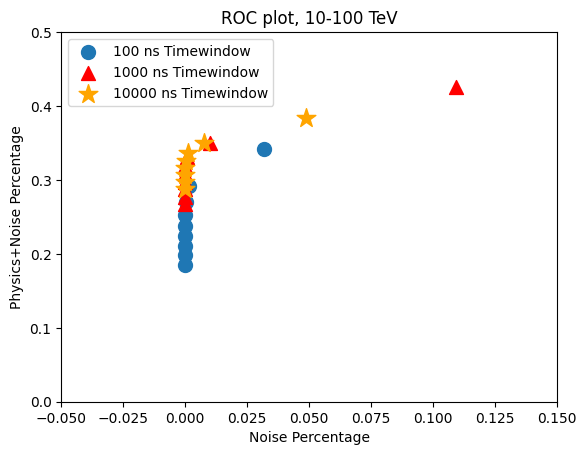

In [1500]:
x_100=counts_100_ns[0, 0:10]
y_100=counts_100_ns[1, 0:10]
x_1000=counts_1000_ns[0, 0:10]
y_1000=counts_1000_ns[1, 0:10]
x_10000=counts_10000_ns[0, 0:10]
y_10000=counts_10000_ns[1, 0:10]
plt.scatter(x_100,y_100, label="100 ns Timewindow", s=100)
plt.scatter(x_1000,y_1000, c="r", marker="^", label="1000 ns Timewindow", s=100)
plt.scatter(x_10000,y_10000, c="orange", marker="*", label="10000 ns Timewindow", s=200)
plt.ylim(bottom=0, top=0.5)
plt.xlim(left=-0.05, right=0.15)
plt.legend()
plt.xlabel("Noise Percentage")
plt.ylabel("Physics+Noise Percentage")

plt.title("ROC plot, 10-100 TeV")
plt.savefig('ROCplot_pmt_zoom.png')
plt.show()

In [1375]:
print(x_1000)
print(y_1000)

[0.10906894 0.0098806 ]
[0.26132008 0.17040608]


## Now I'm going to check how many hits there are for each event

In [10]:
signal_glob=glob.glob('/i3store/users/gen2/22450/0000000-0000999/NuGen*')
signal_array, signal_length=get_data(signal_glob, 1000)
print("Length of signal array=" + str(signal_length))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Length of signal array=83798215


In [11]:
print(signal_array)

[[[9.97666802e+05 1.00000000e+00 1.00100000e+03 3.00000000e+00
   3.00000000e+00 1.01283235e+06]
  [9.97666802e+05 1.00000000e+00 1.00100000e+03 5.00000000e+00
   1.30000000e+01 1.02503579e+06]
  [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
   0.00000000e+00 1.00206232e+06]
  ...
  [4.76434856e+05 2.53160000e+04 1.12000000e+03 4.40000000e+01
   6.00000000e+00 2.53160082e+10]
  [4.76434856e+05 2.53160000e+04 1.12000000e+03 4.40000000e+01
   6.00000000e+00 2.53160119e+10]
  [4.76434856e+05 2.53160000e+04 1.12000000e+03 7.50000000e+01
   8.00000000e+00 2.53160216e+10]]]


In [17]:
print(signal_array)

[[9.97666802e+05 1.00000000e+00 1.00100000e+03 3.00000000e+00
  3.00000000e+00 1.01283235e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 5.00000000e+00
  1.30000000e+01 1.02503579e+06]
 [9.97666802e+05 1.00000000e+00 1.00100000e+03 8.00000000e+00
  0.00000000e+00 1.00206232e+06]
 ...
 [4.76434856e+05 2.53160000e+04 1.12000000e+03 4.40000000e+01
  6.00000000e+00 2.53160082e+10]
 [4.76434856e+05 2.53160000e+04 1.12000000e+03 4.40000000e+01
  6.00000000e+00 2.53160119e+10]
 [4.76434856e+05 2.53160000e+04 1.12000000e+03 7.50000000e+01
  8.00000000e+00 2.53160216e+10]]


In [18]:
def list_of_arrays_by_event(array, event_column, first_event):
    event_phys=array[:,event_column].tolist()
    index=[]
    sum_phys=0
    last_event=first_event
    for event in event_phys:
        if event!=last_event:
            index.append(sum_phys) 
            last_event=event
        sum_phys+=1
    list_of_arrays=np.split(array, index)
    return list_of_arrays

In [19]:
list_event_signal=list_of_arrays_by_event(signal_array, 1, 1)

In [21]:
print(list_event_signal[5])

[[2.09813071e+04 6.00000000e+00 1.00100000e+03 2.40000000e+01
  1.20000000e+01 6.01944779e+06]
 [2.09813071e+04 6.00000000e+00 1.00100000e+03 2.40000000e+01
  1.20000000e+01 6.01945520e+06]
 [2.09813071e+04 6.00000000e+00 1.00100000e+03 2.40000000e+01
  1.20000000e+01 6.01957303e+06]
 ...
 [2.09813071e+04 6.00000000e+00 1.12000000e+03 7.10000000e+01
  7.00000000e+00 6.00276216e+06]
 [2.09813071e+04 6.00000000e+00 1.12000000e+03 7.10000000e+01
  7.00000000e+00 6.00279842e+06]
 [2.09813071e+04 6.00000000e+00 1.12000000e+03 7.10000000e+01
  7.00000000e+00 6.00508884e+06]]


In [22]:
def list_of_arrays_by_string(array, string_column, first_string):
    string_phys=array[:,string_column].tolist()
    index=[]
    sum_phys=0
    last_string=first_string
    for string in string_phys:
        if string!=last_string:
            index.append(sum_phys) 
            last_string=string
        sum_phys+=1
    list_of_arrays=np.split(array, index)
    return list_of_arrays

In [23]:
def sort_by_time(list_of_arrays, time_column):
    for index1, event in enumerate(list_of_arrays):
        for index2, string in enumerate(event):
            list_of_arrays[index1][index2]=sort_array_time(string, time_column)

In [24]:
for index, event in enumerate(list_event_signal):
    list_event_signal[index]=list_of_arrays_by_string(event, 2, 1001)
    

In [25]:
print(list_event_signal[0][7])

[[9.97666802e+05 1.00000000e+00 1.00800000e+03 7.00000000e+00
  9.00000000e+00 1.00884391e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 7.00000000e+00
  9.00000000e+00 1.02309783e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 1.20000000e+01
  4.00000000e+00 1.01893093e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 1.20000000e+01
  4.00000000e+00 1.02752811e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 1.20000000e+01
  7.00000000e+00 1.02729566e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 1.40000000e+01
  2.00000000e+00 1.02201237e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 2.30000000e+01
  3.00000000e+00 1.00359652e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 2.30000000e+01
  7.00000000e+00 1.00341998e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 2.30000000e+01
  7.00000000e+00 1.00372033e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 2.30000000e+01
  7.00000000e+00 1.01450076e+06]
 [9.97666802e+05 1.00000000e+00 1.00800000e+03 2.4

In [26]:
list_event_string_signal=list_event_signal

In [29]:
sort_by_time(list_event_string_signal,5)

In [30]:
print(list_event_string_signal[5][2])

[[2.09813071e+04 6.00000000e+00 1.00300000e+03 3.30000000e+01
  2.00000000e+00 5.99482064e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 4.30000000e+01
  4.00000000e+00 5.99509587e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 4.30000000e+01
  4.00000000e+00 5.99548054e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 1.00000000e+00
  1.20000000e+01 5.99593129e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 4.30000000e+01
  4.00000000e+00 5.99675757e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 4.30000000e+01
  4.00000000e+00 5.99839983e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 4.30000000e+01
  4.00000000e+00 5.99918691e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 4.30000000e+01
  4.00000000e+00 5.99931576e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 9.00000000e+00
  3.00000000e+00 6.00007828e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 4.30000000e+01
  4.00000000e+00 6.00013340e+06]
 [2.09813071e+04 6.00000000e+00 1.00300000e+03 4.3

In [55]:
def number_of_hits(list_of_arrays, nanoseconds, dom_column, pmt_column, time_column, dom_limit, pmt_hits):
    
    #This functions takes a list of a list of arrays, first split by event, then by string.
    count=0
    hit_distrib=[]
    total_hits_event=[]
    
    for event in list_of_arrays:
        
        total_hits=0
        
        # Set the number of hits so far for this even equal to 0
        hits=0
        for string in event:
            
            count+=1
            if count%40==0:
                print(count)
            
            total_hits+=len(string)
            
            string2=string
            for pulse in string:
                temp=[]
                other_pmt_count=0
                
                #this other array will contain all the pulses that occured after this one
                string2=np.delete(string2, 0, axis=0)
            
                #Loop through until nanoseconds are exceeded
                i=0
                while i<len(string2) and (string2[i,time_column]-pulse[time_column])<nanoseconds:
                    #If DOMS are the same and PMTs are different
                    if pulse[dom_column]==string2[i,dom_column]:
                        if (pulse[pmt_column]!=string2[i,pmt_column]) and (string2[i,pmt_column] not in temp):
                            #count how many "other" pmts are hit
                            other_pmt_count+=1
                            temp.append(string2[i,pmt_column])
                        
                            #if other pmts hit is equal to 2, mark the pulse as a hit and stop going through the while loop
                            if other_pmt_count==pmt_hits:
                                hits+=1
                                break

                    #If DOMS are different but 2 or less away,
                    if abs(pulse[dom_column]-string2[i,dom_column])<=dom_limit and pulse[dom_column]!=string2[i,dom_column]:
                        #count it as a hit, and stop going through the while loop
                        hits+=1
                        break
                    
                    
                    #increment the while loop                
                    i+=1
        hit_distrib.append(hits)
        total_hits_event.append(total_hits)
    return hit_distrib, total_hits_event

In [35]:
signal_hit_distr_2, signal_total_hits_event_2=number_of_hits(list_event_string_signal, nanoseconds=1000, dom_column=3, pmt_column=4, time_column=5, dom_limit=2, pmt_hits=2)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000


In [36]:
signal_hit_distr_1, signal_total_hits_event_1=number_of_hits(list_event_string_signal, nanoseconds=1000, dom_column=3, pmt_column=4, time_column=5, dom_limit=2, pmt_hits=1)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000


In [38]:
noise_glob=glob.glob('/i3store/users/gen2/22449/0000000-0000999/RandomNoise*')
noise_array, noise_length=get_data(noise_glob, 1)
print("Length of noise array=" + str(noise_length))

0
1
2
3
4
5
6
7
8
9
Length of noise array=81410615


In [39]:
print(noise_array)

[[[1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
   1.38686509e+06]
  [1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
   7.62587787e+06]
  [1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
   7.62923905e+06]
  ...
  [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
   9.49183417e+07]
  [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
   9.58993431e+07]
  [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
   9.59011561e+07]]]


In [40]:
noise_array=reshape(noise_array)

In [41]:
print(noise_array)

[[1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  1.38686509e+06]
 [1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  7.62587787e+06]
 [1.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  7.62923905e+06]
 ...
 [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.49183417e+07]
 [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.58993431e+07]
 [1.00000000e+01 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.59011561e+07]]


In [42]:
list_event_noise=list_of_arrays_by_event(noise_array, 0, 1)

In [43]:
print(list_event_noise[5])

[[6.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  2.16731513e+07]
 [6.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  2.28771129e+07]
 [6.00000000e+00 1.00100000e+03 1.00000000e+00 0.00000000e+00
  2.28839723e+07]
 ...
 [6.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  9.38912210e+07]
 [6.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  1.04244746e+08]
 [6.00000000e+00 1.12000000e+03 8.00000000e+01 1.40000000e+01
  1.04247925e+08]]


In [44]:
for index, event in enumerate(list_event_noise):
    list_event_noise[index]=list_of_arrays_by_string(event, 1, 1001)
    

In [45]:
print(list_event_noise[0][7])

[[1.00000000e+00 1.00800000e+03 1.00000000e+00 0.00000000e+00
  9.87413564e+05]
 [1.00000000e+00 1.00800000e+03 1.00000000e+00 0.00000000e+00
  4.60921438e+06]
 [1.00000000e+00 1.00800000e+03 1.00000000e+00 0.00000000e+00
  1.78998797e+07]
 ...
 [1.00000000e+00 1.00800000e+03 8.00000000e+01 1.40000000e+01
  8.92902457e+07]
 [1.00000000e+00 1.00800000e+03 8.00000000e+01 1.40000000e+01
  9.99180173e+07]
 [1.00000000e+00 1.00800000e+03 8.00000000e+01 1.40000000e+01
  9.99200719e+07]]


In [46]:
list_event_string_noise=list_event_noise

In [47]:
sort_by_time(list_event_string_noise,4)

In [48]:
print(list_event_string_noise[0][7])

[[1.00000000e+00 1.00800000e+03 6.70000000e+01 1.40000000e+01
  8.35023687e+05]
 [1.00000000e+00 1.00800000e+03 6.70000000e+01 1.40000000e+01
  8.35044500e+05]
 [1.00000000e+00 1.00800000e+03 5.00000000e+00 9.00000000e+00
  8.35892513e+05]
 ...
 [1.00000000e+00 1.00800000e+03 3.70000000e+01 9.00000000e+00
  1.00829385e+08]
 [1.00000000e+00 1.00800000e+03 7.70000000e+01 1.10000000e+01
  1.00831349e+08]
 [1.00000000e+00 1.00800000e+03 3.70000000e+01 9.00000000e+00
  1.00831548e+08]]


In [56]:
noise_hit_distr_2, noise_total_hits_event_2=number_of_hits(list_event_string_noise, nanoseconds=1000, dom_column=2, pmt_column=3, time_column=4, dom_limit=2, pmt_hits=2)

40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000
1040
1080
1120
1160
1200


In [57]:
noise_hit_distr_1, noise_total_hits_event_1=number_of_hits(list_event_string_noise, nanoseconds=1000, dom_column=2, pmt_column=3, time_column=4, dom_limit=2, pmt_hits=1)

40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000
1040
1080
1120
1160
1200


In [61]:
percent_hits_signal_1_pmt=[i/j for i, j in zip(signal_hit_distr_1, signal_total_hits_event_1)]

In [62]:
percent_hits_signal_2_pmt=[i/j for i, j in zip(signal_hit_distr_2, signal_total_hits_event_2)]

In [64]:
percent_hits_noise_1_pmt=[i/j for i, j in zip(noise_hit_distr_1, noise_total_hits_event_1)]

In [63]:
percent_hits_noise_2_pmt=[i/j for i, j in zip(noise_hit_distr_2, noise_total_hits_event_2)]

In [66]:
def check_this(list_1):
    for element in list_1:
        if element>1:
            print("error")

## Earlier Graphs for learning Numpy and Matplotlib

Here I graphed, a LOT of the data for multiple hits on a single DOM and a single PMT on noise and signal data files.

In [241]:
def multiple_hit_dom(array):
    mult_hits=[]
    for first_dim in array:
        temp_dom=0
        prev_event=None
        prev_str=None
        prev_mod=None
        for row in first_dim:
            if (row[0]!=prev_event or row[1]!=prev_str or row[2]!=prev_mod):
                #you're no longer working on the same DOM, so see if it had multiple hits, and if so add it to the sum.
                if temp_dom>1:
                    mult_hits.append(temp_dom)
            
                #prepare to compare the next hit to this DOM
                prev_event=row[0]
                prev_str=row[1]
                prev_mod=row[2]
                temp_dom=1
            else:
                #this hit is on the same DOM as the last one, so 
                temp_dom+=1
        if temp_dom>1:
                    mult_hits.append(temp_dom)
    return mult_hits, sum(mult_hits)

In [242]:
dom_physics_hits_list, dom_physics_hits=multiple_hit_dom(physics_array)
print(dom_physics_hits)
print(physics_length)
print(dom_physics_hits/physics_length)


73777194
83798215
0.8804148632521588


In [243]:
dom_noise_hits_list, dom_noise_hits=multiple_hit_dom(noise_array)
print(dom_noise_hits)
print(noise_length)
print(dom_noise_hits/noise_length)

81410615
81410615
1.0


In [245]:
def multiple_hit_pmt(array):
    mult_hits=[]
    temp_pmt=0
    prev_event=None
    prev_str=None
    prev_mod=None
    prev_pmt=None
    for first_dim in array:
        for row in first_dim:
            if (row[0]!=prev_event or row[1]!=prev_str or row[2]!=prev_mod or row[3]!=prev_pmt):
                #you're no longer working on the same DOM, so see if it had multiple hits, and if so add it to the sum.
                if temp_pmt>1:
                    mult_hits.append(temp_pmt)
            
                #prepare to compare the next hit to this DOM
                prev_event=row[0]
                prev_str=row[1]
                prev_mod=row[2]
                prev_pmt=row[3]
                temp_pmt=1
            else:
                #this hit is on the same DOM as the last one, so 
                temp_pmt+=1
        if temp_pmt>1:
                    mult_hits.append(temp_pmt)
    return mult_hits, sum(mult_hits)

In [246]:
pmt_physics_hits_list, pmt_physics_hits=multiple_hit_pmt(physics_array)
print(pmt_physics_hits)
print(physics_length)
print(pmt_physics_hits/physics_length)


66524308
83798215
0.7938630673696331


In [247]:
pmt_noise_hits_list, pmt_noise_hits=multiple_hit_pmt(noise_array)
print(pmt_noise_hits)
print(noise_length)
print(pmt_noise_hits/noise_length)


81410587
81410615
0.999999656064507


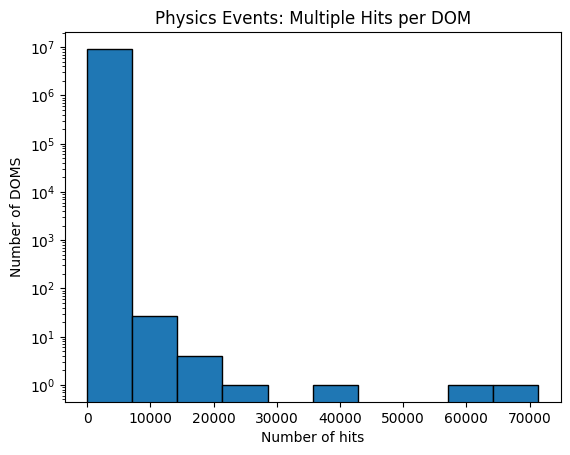

In [262]:

plt.hist(dom_physics_hits_list, edgecolor='black', log=True)
plt.title("Physics Events: Multiple Hits per DOM")
plt.xlabel("Number of hits")
plt.ylabel("Number of DOMS")
plt.save("
plt.show()

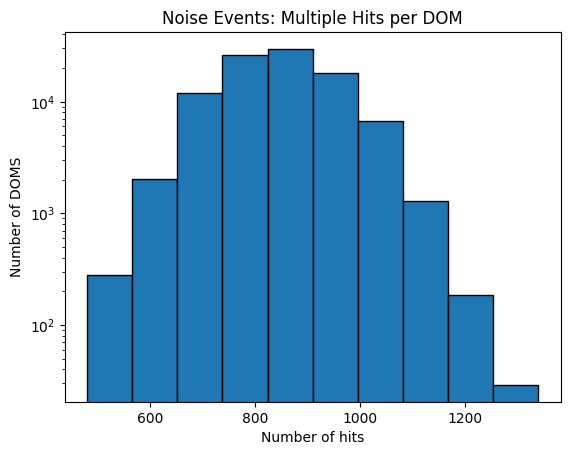

In [269]:
bins=range(0,1400, 50)
plt.hist(dom_noise_hits_list, edgecolor='black', log=True)
plt.title("Noise Events: Multiple Hits per DOM")
plt.xlabel("Number of hits")
plt.ylabel("Number of DOMS")
plt.show()

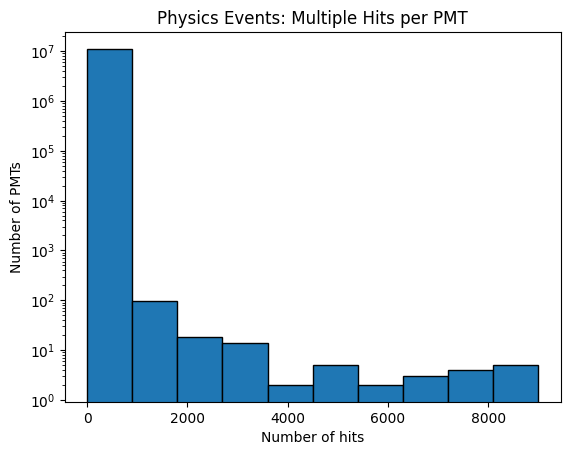

In [268]:

plt.hist(pmt_physics_hits_list, edgecolor='black', log=True)
plt.title("Physics Events: Multiple Hits per PMT")
plt.xlabel("Number of hits")
plt.ylabel("Number of PMTs")
plt.show()

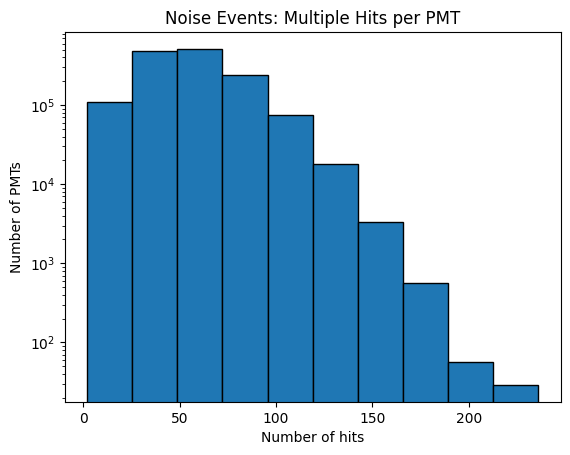

In [270]:

plt.hist(pmt_noise_hits_list, edgecolor='black', log=True)
plt.title("Noise Events: Multiple Hits per PMT")
plt.xlabel("Number of hits")
plt.ylabel("Number of PMTs")
plt.show()

## Make an example plot
Now that we have stuff, let's plot something from it.

I'll just be plotting the number of hits for each module first.

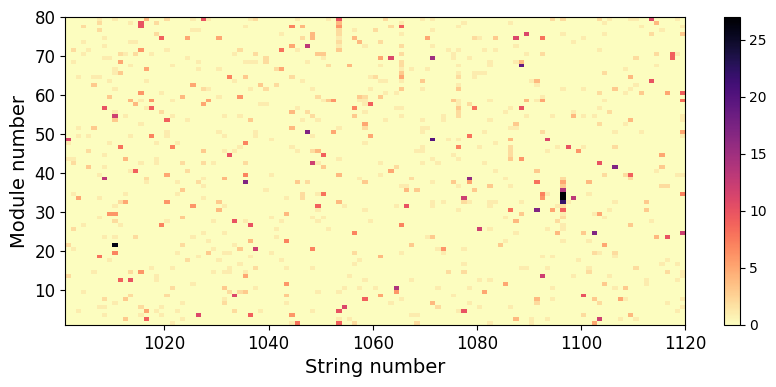

In [130]:


#---------------------------------------
# Make a "figure" (the canvas that our image will go on)
# and an "axis" (the specific area we want to draw in)
#---------------------------------------
fig, ax = plt.subplots(figsize=(10,4))

#---------------------------------------
# Choose the bins we want to use for plotting.
#---------------------------------------
string_bins = range(string.min(), string.max()+1)
module_bins = range(module.min(), module.max()+1)

#---------------------------------------
# Plot a 2d histogram of string number and module number
# using a colormap from matplotlib
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
#
# The "LogNorm()" here will put the colorbar on a log-scale, which
# can make it a bit easier to read. Try uncommenting to see the plot
# with a logarithmic colorbar scale.
#---------------------------------------
hist, xbins, ybins = np.histogram2d(string, module,
                                    bins = (string_bins, module_bins))

cmesh = ax.pcolormesh(xbins, ybins, hist.T,
                      cmap = 'magma_r', # "_r" added to reverse the colormap
                      #norm = LogNorm(),
                      )

#---------------------------------------
# Add a colorbar
#---------------------------------------
plt.colorbar(cmesh, ax=ax)

#---------------------------------------
# And now add axis labels and make things
# look like you actually care enough to
# put some effort in.
# I *strongly* encourage you to try commenting
# and changing these to see what they do
# and find a plotting style that you like.
#---------------------------------------
ax.set_xlabel("String number", fontsize=14)
ax.set_ylabel("Module number", fontsize=14)
ax.tick_params(labelsize=12)

#---------------------------------------
# Save it!
#---------------------------------------
plt.savefig("module_vs_string_hits.pdf")

## What do you need to do?

This example reads out hits from a single file (in my case, 
from a signal neutrino file) and gives you access to the 
hit position and time for each hit. You should modify this
script so that you can read both a physics and a noise file
and get arrays for both separately. 

## Find cases where we have multiple hits on a single PMT
Once you have those, then I want you to look for cases where
you have multiple hits on a single module (ie, where the
event, string, and module are all the same, but you have 
multiple hits). You can find these with simple python code in
a `for` loop. Remember that our code earlier read each hit on
a single PMT before moving to the next one, so you need that does

>for each pulse:
>
>       for each other pulse
>               if different string or different module or different pmt: stop
>               else: do stuff

How often do we see multiple hits on a single PMT in signal simulation
 (ie, what fraction of the total hits)?
How often do we see multiple hits on a single PMT in noise simulation?
Make histograms of the two so we can compare them.

## How many hits are nearby?
How far away (how many modules up or down the string) do you need to look
in order to find the nearest hit in 1 microsecond? Note that the times we
pulled from the i3 file are in nanoseconds. Calculate this for every hit
in a single signal event. Do the same for a noise-only event. Make plots
showing the distributions for physics and noise.

Make the same calculation for the nearest hit in 100 nanoseconds. Do it
again for 10 microseconds.

Note: You can implement this using the lists we've already extracted or
you can do this by modifying the i3file loop earlier (and only save the
information you actually care about). Either can work, so try both to see
what you're comfortable with and what feels more natural. Personally, I'd
probably change the i3file loop.

## This is the code that determined which time and DOM limitations were the most useful

Some of this code, like physics_hit_distribution is slow, and I made better but similar functions later

In [594]:
def minimum_difference(input_list, input_value):
    arr = np.asarray(input_list)
    i = (np.abs(arr - input_value)).argmin()
    difference=abs(arr[i]-input_value)
    return difference

In [28]:
#sort function
def sort_array_time(input_array, column):
    order = input_array[:, column].argsort()
    sorted = np.take(input_array, order, 0)
    return sorted

In [673]:
#function takes array, nanosecond limitation, returns list of how far away the nearest hit on the same string is
def physics_hit_distribution(array, nanoseconds):
    list_distribution=[]
    no_hits_nearby=0
    
    for first_dim in array:
        for index, original_pulse in enumerate(first_dim):
            temp=[]
            og_string=original_pulse[1]
            og_dom=original_pulse[2]
            og_time=original_pulse[4]
            
            array2=np.delete(first_dim, index, axis=0)

            for other_pulse in array2:
                
                oth_string=other_pulse[1]
                oth_dom=other_pulse[2]
                oth_time=other_pulse[4]
                
                if og_string==oth_string and (oth_time-og_time)>0 and (oth_time-og_time)<nanoseconds:
                    temp.append(oth_dom) 
            
            if temp==[]:
                no_hits_nearby+=1
            else:
                list_distribution.append(minimum_difference(temp, og_dom))
    return list_distribution, no_hits_nearby
        


In [868]:
#creating a different faster function to go through the enormous noise files
def noise_hit_distribution(list_of_arrays, nanoseconds):
    list_distribution=[]
    no_hits_nearby=0
    count=0
    for array in list_of_arrays:
        count+=1
        if count%1000==0:
            print(count)
        array2=array
        for pulse in array:
            temp=[]
            array2=np.delete(array2, 0, axis=0)
            
            i=0
            while i<len(array2) and (array2[i,2]-pulse[2])<nanoseconds:
                if pulse[1]!=array2[i,1]:
                    temp.append(array2[i,1])
                i+=1
            
            if temp==[]:
                no_hits_nearby+=1
            else:
                list_distribution.append(minimum_difference(temp, pulse[1]))
    return list_distribution, no_hits_nearby

The functions are defined above, then take data below

In [862]:

physics_file = glob.glob("/i3store/users/gen2/22450/0000000-0000999/NuGen_NuMu_Gen2_LOM16_240m_0.i3.zst")
mult_physics_event, length_physics =get_data(physics_file, count=100)

100
200
300
400
500


In [ ]:
noise_file= glob.glob("/i3store/users/gen2/22449/0000000-0000999/RandomNoise_Gen2_LOM16_240m_0.i3.zst")
single_noise_event, length_noise=get_data(noise_file, count=5)

In [863]:
print(mult_physics_event)

[[[1.00000000e+00 1.00100000e+03 3.00000000e+00 3.00000000e+00
   1.01283235e+06]
  [1.00000000e+00 1.00100000e+03 5.00000000e+00 1.30000000e+01
   1.02503579e+06]
  [1.00000000e+00 1.00100000e+03 8.00000000e+00 0.00000000e+00
   1.00206232e+06]
  ...
  [5.00000000e+02 6.10000000e+04 7.70000000e+01 9.00000000e+00
   5.00010968e+08]
  [5.00000000e+02 6.10000000e+04 7.70000000e+01 9.00000000e+00
   5.00021030e+08]
  [5.00000000e+02 6.10000000e+04 7.80000000e+01 4.00000000e+00
   5.00016862e+08]]]


In [675]:
physics_hit_distribution_1000, no_hits_p1000=physics_hit_distribution(single_physics_event,1000)
physics_hit_distribution_100, no_hits_p100=physics_hit_distribution(single_physics_event, 100)
physics_hit_distribution_10000, no_hits_p10000=physics_hit_distribution(single_physics_event,10000)


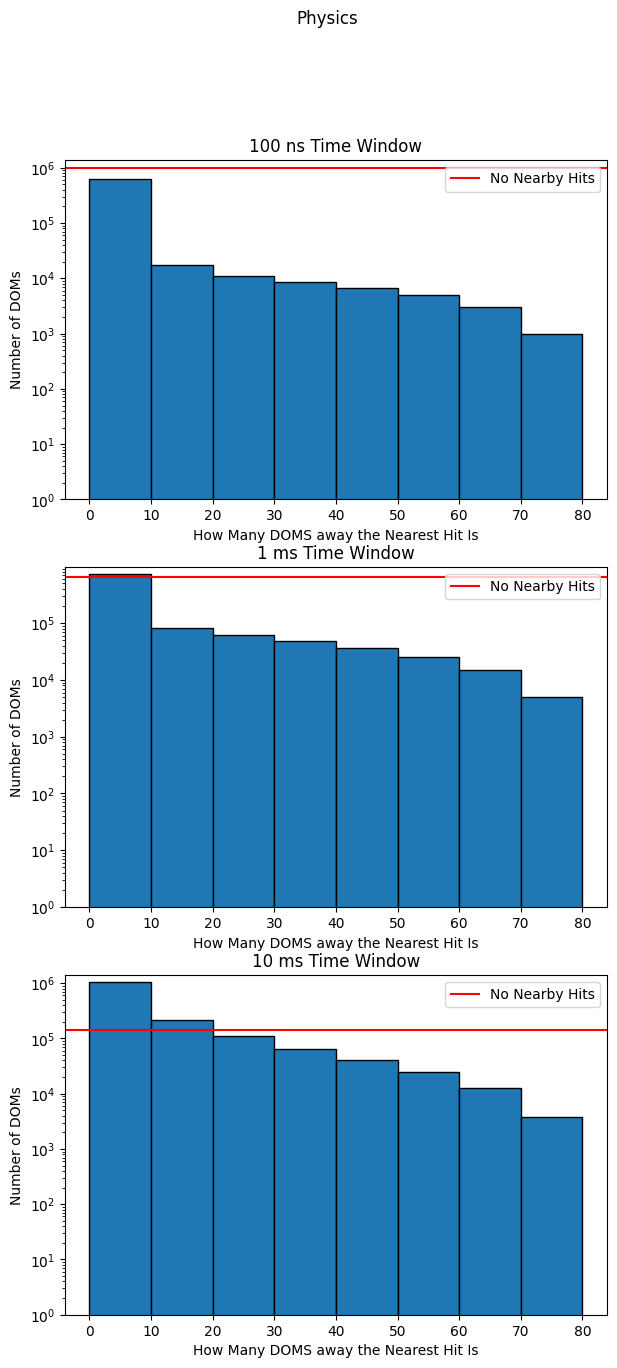

In [874]:
bins=range(0, 81,10)

fig, (ax0, ax1, ax2)=plt.subplots(3,1, figsize=(7,15))
#plot 1, physics, 100 ns
ax0.hist(physics_hit_distribution_100, bins=bins, edgecolor="black", log=True)
ax0.axhline(no_hits_p100, color="red", label="No Nearby Hits")
ax0.set_title("100 ns Time Window")
ax0.set_xlabel("How Many DOMS away the Nearest Hit Is")
ax0.set_ylabel("Number of DOMs")
ax0.legend()
ax0.set_ylim(bottom=1)

#plot 2 physics 1microsecond
ax1.hist(physics_hit_distribution_1000, bins=bins, edgecolor="black", log=True)
ax1.axhline(no_hits_p1000, color="red", label="No Nearby Hits")
ax1.set_title("1 ms Time Window")
ax1.set_xlabel("How Many DOMS away the Nearest Hit Is")
ax1.set_ylabel("Number of DOMs")
ax1.legend()
ax1.set_ylim(bottom=1)

#plot 3 physics 10 microsecond
ax2.hist(physics_hit_distribution_10000, bins=bins, edgecolor="black", log=True)
ax2.axhline(no_hits_p10000, color="red", label="No Nearby Hits")
ax2.set_title("10 ms Time Window")
ax2.set_xlabel("How Many DOMS away the Nearest Hit Is")
ax2.set_ylabel("Number of DOMs")
ax2.legend()
ax2.set_ylim(bottom=1)

fig.suptitle("Physics")
fig.savefig('physics_timing_graphs.png')
fig.show()


In [869]:
physics_hit_distribution_1000, no_hits_p1000=noise_hit_distribution(list_of_physics_arrays,1000)
print("1000 finished")
physics_hit_distribution_100, no_hits_p100=noise_hit_distribution(list_of_physics_arrays, 100)
print("100 finished")
physics_hit_distribution_10000, no_hits_p10000=noise_hit_distribution(list_of_physics_arrays,10000)
print("10000 finished")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
1000 finished
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
100 finished
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
4700

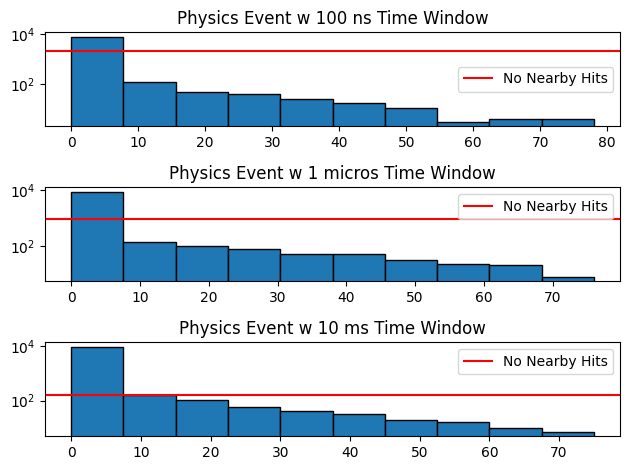

In [681]:
#plot 1, physics, 100 ns
plt.subplot(3, 1, 1)
plt.hist(physics_hit_distribution_100, edgecolor="black", log=True)
plt.axhline(no_hits_p100, color="red", label="No Nearby Hits")
plt.title("Physics Event w 100 ns Time Window")
plt.legend()
plt.tight_layout()

#plot 2 physics 1microsecond
plt.subplot(3, 1, 2)
plt.hist(physics_hit_distribution_1000, edgecolor="black", log=True)
plt.axhline(no_hits_p1000, color="red", label="No Nearby Hits")
plt.title("Physics Event w 1 micros Time Window")
plt.legend()
plt.tight_layout()

#plot 3 physics 10 microsecond
plt.subplot(3, 1, 3)
plt.hist(physics_hit_distribution_10000, edgecolor="black", log=True)
plt.axhline(no_hits_p10000, color="red", label="No Nearby Hits")
plt.title("Physics Event w 10 ms Time Window")
plt.legend()
plt.tight_layout()

plt.show()

Noise is going to be a lot longer, so to save processing time I'm reshaping the array, getting rid of unnecessary data, splitting it by string, then sorting those arrays by time.

In [682]:
#Reshaping, then deleting unnecessary data
shape_noise=np.shape(single_noise_event)
new_shape_noise=np.delete(shape_noise,0)
better_event_noise=np.reshape(single_noise_event,new_shape_noise)
better_event_1_noise=np.delete(better_event_noise,[0, 3], axis=1)

In [683]:
#indexing in order to split by string
strings_noise=better_event_1_noise[:,1].tolist()
index_noise=[]
sum_noise=0
for string_noise in range(1001, 1120):
    sum_noise+=strings_noise.count(string_noise)
    index_noise.append(sum_noise)    

In [684]:
#creating a list of arrays, each of them is a single string
list_of_noise_arrays=np.split(better_event_1_noise,index_noise)


In [685]:
#sorting the arrays by time
for index1, array1 in enumerate(list_of_noise_arrays):
    list_of_noise_arrays[index1]=sort_array_time(array1, 2)

print(list_of_noise_arrays[0][0:15])

[[1.00100000e+03 3.40000000e+01 8.36513551e+05]
 [1.00100000e+03 3.40000000e+01 8.36600964e+05]
 [1.00100000e+03 3.40000000e+01 8.37217585e+05]
 [1.00100000e+03 7.60000000e+01 8.37290835e+05]
 [1.00100000e+03 3.40000000e+01 8.37753555e+05]
 [1.00100000e+03 3.40000000e+01 8.39429862e+05]
 [1.00100000e+03 3.40000000e+01 8.39596962e+05]
 [1.00100000e+03 3.40000000e+01 8.40027242e+05]
 [1.00100000e+03 3.40000000e+01 8.41883357e+05]
 [1.00100000e+03 2.00000000e+00 8.42982917e+05]
 [1.00100000e+03 2.00000000e+00 8.45376054e+05]
 [1.00100000e+03 2.70000000e+01 8.45916806e+05]
 [1.00100000e+03 2.00000000e+00 8.46315742e+05]
 [1.00100000e+03 2.70000000e+01 8.48376447e+05]
 [1.00100000e+03 2.00000000e+00 8.51443357e+05]]


In [864]:
shape_physics=np.shape(mult_physics_event)
new_shape_physics=np.delete(shape_physics,0)
better_physics_event=np.reshape(mult_physics_event, new_shape_physics)
better_physics_event_1=np.delete(better_physics_event,[0, 3], axis=1)

In [867]:
#indexing in order to split by string
strings_physics=better_physics_event_1[:,0].tolist()
index_physics=[]
sum_physics=0
count=0
for string_physics in range(1001, 61000):
    if count%1000==0:
        print(count)
    count+=1
    sum_physics+=strings_physics.count(string_physics)
    index_physics.append(sum_physics)

#creating a list of arrays, each of them is a single string
list_of_physics_arrays=np.split(better_physics_event_1,index_physics)

#sorting the arrays by time
for index, array in enumerate(list_of_physics_arrays):
    list_of_physics_arrays[index]=sort_array_time(array, 2)
    
print(list_of_physics_arrays[0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
[[1.00100000e+03 4.20000000e+01 1.00084263e+06]
 [1.00100000e+03 4.20000000e+01 1.00085808e+06]
 [1.00100000e+03 4.20000000e+01 1.00086646e+06]
 [1.00100000e+03 4.20000000e+01 1.00088119e+06]
 [1.00100000e+03 4.20000000e+01 1.00089026e+06]
 [1.00100000e+03 4.20000000e+01 1.00090060e+06]
 [1.00100000e+03 4.20000000e+01 1.00091394e+06]
 [1.00100000e+03 4.20000000e+01 1.00092917e+06]
 [1.00100000e+03 4.20000000e+01 1.00099372e+06]
 [1.00100000e+03 4.20000000e+01 1.00109404e+06]
 [1.00100000e+03 4.20000000e+01 1.00139509e+06]
 [1.00100000e+03 4.20000000e+01 1.00180812e+06]
 [1.00100000e+03 4.20000000e+01 1.00191765e+06]
 [1.00100000e+03 8.00000000e+

In [697]:
noise_hit_distribution_1000, no_hits_n1000=noise_hit_distribution(list_of_arrays,1000)
print("1000 finished")
noise_hit_distribution_100, no_hits_n100=noise_hit_distribution(list_of_arrays, 100)
print("100 finished")
noise_hit_distribution_10000, no_hits_n10000=noise_hit_distribution(list_of_arrays,10000)
print("10000 finished")

1000 finished
100 finished
10000 finished


In [698]:
time_noise=noise_time_sort[-1]-noise_time_sort[0]
time_phys=physics_time_sort[-1]-physics_time_sort[0]

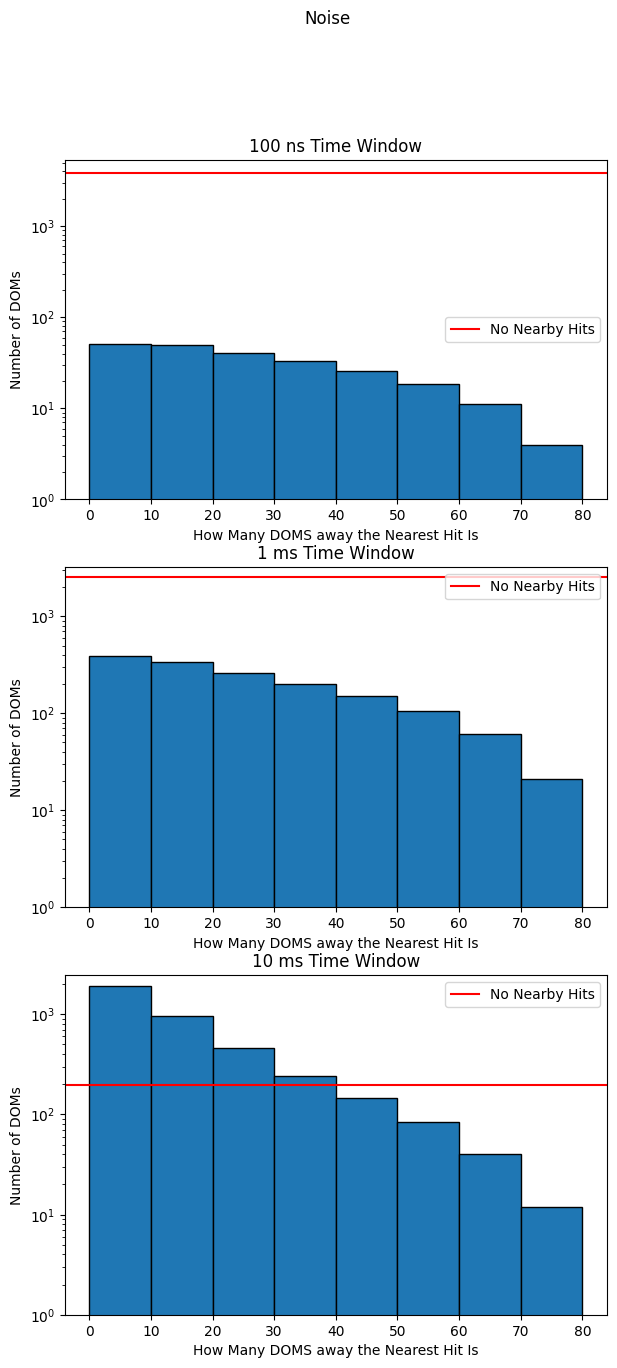

In [702]:
bins=range(0, 81,10)
weight=time_phys/time_noise
weights=[weight]*len(noise_hit_distribution_100)
fig, (ax0, ax1, ax2)=plt.subplots(3,1, figsize=(7,15))
#plot 1, physics, 100 ns
ax0.hist(noise_hit_distribution_100, bins=bins, weights=weights, edgecolor="black", log=True)
ax0.axhline(no_hits_n100*weight, color="red", label="No Nearby Hits")
ax0.set_title("100 ns Time Window")
ax0.set_xlabel("How Many DOMS away the Nearest Hit Is")
ax0.set_ylabel("Number of DOMs")
ax0.legend()
ax0.set_ylim(bottom=1)

#plot 2 physics 1microsecond
weights=[weight]*len(noise_hit_distribution_1000)
ax1.hist(noise_hit_distribution_1000, bins=bins, weights=weights, edgecolor="black", log=True)
ax1.axhline(no_hits_n1000*weight, color="red", label="No Nearby Hits")
ax1.set_title("1 ms Time Window")
ax1.set_xlabel("How Many DOMS away the Nearest Hit Is")
ax1.set_ylabel("Number of DOMs")
ax1.legend()
ax1.set_ylim(bottom=1)

#plot 3 physics 10 microsecond
weights=[weight]*len(noise_hit_distribution_10000)
ax2.hist(noise_hit_distribution_10000, bins=bins, weights=weights, edgecolor="black", log=True)
ax2.axhline(no_hits_n10000*weight, color="red", label="No Nearby Hits")
ax2.set_title("10 ms Time Window")
ax2.set_xlabel("How Many DOMS away the Nearest Hit Is")
ax2.set_ylabel("Number of DOMs")
ax2.legend()
ax2.set_ylim(bottom=1)

fig.suptitle("Noise")
fig.savefig('noise_timing_graphs.png')
fig.show()


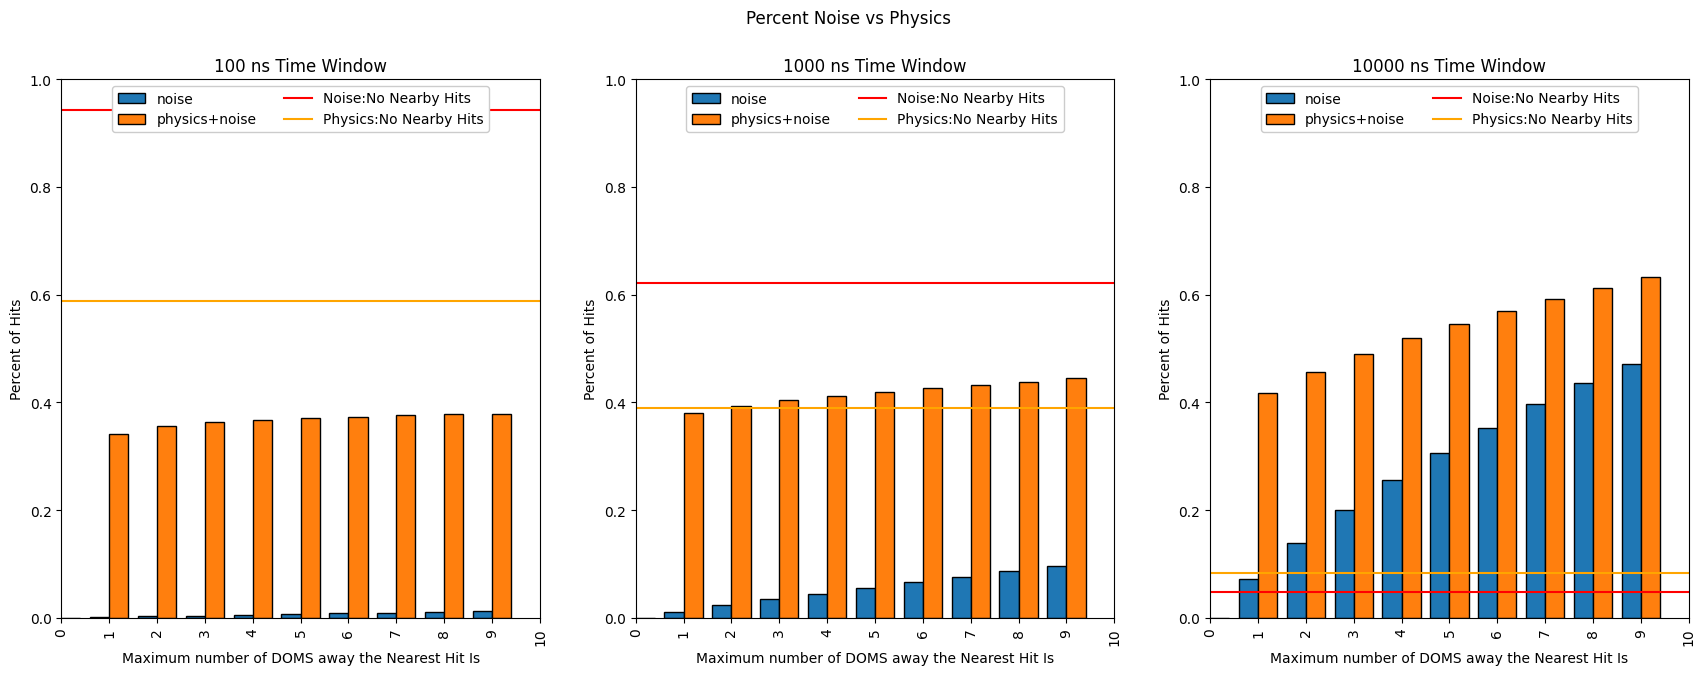

In [1513]:
fig, (ax0, ax1, ax2)=plt.subplots(1,3, figsize=(21,7))
bins=np.arange(11)-0.5
#colors=["blue","orange"]
total_noise_100=len(noise_hit_distribution_100)+no_hits_n100
total_phys_100=len(physics_hit_distribution_100)+no_hits_p100
weight=1
weight1=np.ones(len(noise_hit_distribution_100))*weight/total_noise_100
weight2=np.ones(len(physics_hit_distribution_100))/total_phys_100
counts_100_ns, bin_100, patches_100=ax0.hist([noise_hit_distribution_100, physics_hit_distribution_100], bins=bins, weights=[weight1, weight2],
         label=["noise","physics+noise"], edgecolor="black", cumulative=True)
ax0.axhline(no_hits_n100/total_noise_100, color="red", label="Noise:No Nearby Hits")
ax0.axhline(no_hits_p100/total_phys_100, color="orange", label="Physics:No Nearby Hits")
plt.sca(ax0)
plt.xticks(range(0,21), rotation=90)
ax0.set_title("100 ns Time Window")
ax0.set_xlabel("Maximum number of DOMS away the Nearest Hit Is")
ax0.set_ylabel("Percent of Hits")
ax0.set_ylim(bottom=0, top =1)
ax0.set_xlim(left=0, right=10)
plt.legend(loc='upper center', ncol=2, framealpha=1)


total_noise_1000=len(noise_hit_distribution_1000)+no_hits_n1000
total_phys_1000=len(physics_hit_distribution_1000)+no_hits_p1000
weight1=np.ones(len(noise_hit_distribution_1000))*weight/total_noise_1000
weight2=np.ones(len(physics_hit_distribution_1000))/total_phys_1000
counts_1000_ns, bin_1000, patches_1000=ax1.hist([noise_hit_distribution_1000, physics_hit_distribution_1000], bins=bins, weights=[weight1, weight2],
         label=["noise","physics+noise"], edgecolor="black", cumulative=True)
ax1.axhline(no_hits_n1000/total_noise_1000, color="red", label="Noise:No Nearby Hits")
ax1.axhline(no_hits_p1000/total_phys_1000, color="orange", label="Physics:No Nearby Hits")
plt.sca(ax1)
plt.xticks(range(0,21), rotation=90)
ax1.set_title("1000 ns Time Window")
ax1.set_xlabel("Maximum number of DOMS away the Nearest Hit Is")
ax1.set_ylabel("Percent of Hits")
ax1.set_ylim(bottom=0, top=1)
ax1.set_xlim(left=0, right=10)
plt.legend(loc='upper center', ncol=2, framealpha=1)


total_noise_10000=len(noise_hit_distribution_10000)+no_hits_n10000
total_phys_10000=len(physics_hit_distribution_10000)+no_hits_p10000
weight1=np.ones(len(noise_hit_distribution_10000))*weight/total_noise_10000
weight2=np.ones(len(physics_hit_distribution_10000))/total_phys_10000
counts_10000_ns, bin_10000, patches_10000=ax2.hist([noise_hit_distribution_10000, physics_hit_distribution_10000], bins=bins, weights=[weight1, weight2],
         label=["noise","physics+noise"], edgecolor="black", cumulative=True)
ax2.axhline(no_hits_n10000/total_noise_10000, color="red", label="Noise:No Nearby Hits")
ax2.axhline(no_hits_p10000/total_phys_1000, color="orange", label="Physics:No Nearby Hits")
plt.sca(ax2)
plt.xticks(range(0,21), rotation=90)
ax2.set_title("10000 ns Time Window")
ax2.set_xlabel("Maximum number of DOMS away the Nearest Hit Is")
ax2.set_ylabel("Percent of Hits")
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=0, right=10)
plt.legend(loc='upper center', ncol=2, framealpha=1)

fig.suptitle("Percent Noise vs Physics")
fig.savefig('percent_noise_physics.png')
fig.show()

In [1514]:
print(total_phys_1000)

1678606


In [1491]:
print(y_1000[2])



0.39419375362636005


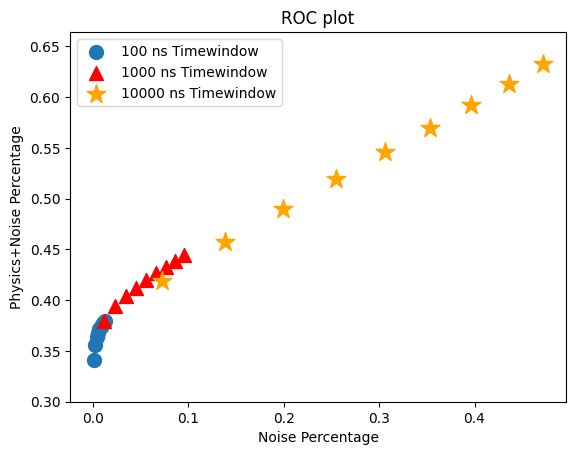

In [1490]:
x_100=counts_100_ns[0]
y_100=counts_100_ns[1]
x_1000=counts_1000_ns[0]
y_1000=counts_1000_ns[1]
x_10000=counts_10000_ns[0]
y_10000=counts_10000_ns[1]
plt.scatter(x_100,y_100, label="100 ns Timewindow", s=100)
plt.scatter(x_1000,y_1000, c="r", marker="^", label="1000 ns Timewindow", s=100)
plt.scatter(x_10000,y_10000, c="orange", marker="*", label="10000 ns Timewindow", s=200)
plt.ylim(bottom=0.3)
plt.legend()
plt.xlabel("Noise Percentage")
plt.ylabel("Physics+Noise Percentage")

plt.title("ROC plot")
plt.savefig('ROCplot.png')
plt.show()

In [891]:
def find_min(x_list,y_list):
    temp=[]
    for x, y in zip(x_list, y_list):
        rate=(1-y)+x
        temp.append(rate)
    minimum=min(temp)
    i=temp.index(minimum)
    return i

In [1383]:
index=find_min(x_1000, y_1000)
print(index)

2


0.5226278563153309
0.3854675345203841


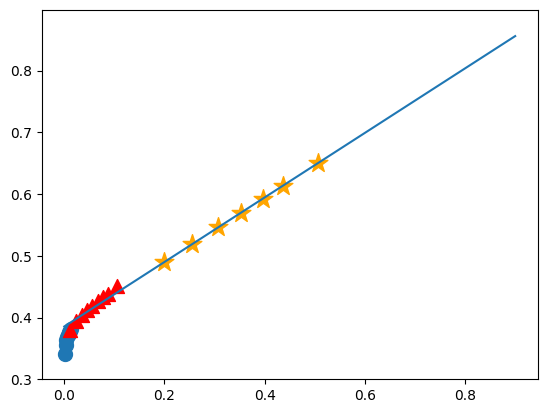

In [911]:
x_10000=np.delete(x_10000,0)
y_10000=np.delete(y_10000,0)
a,b=np.polyfit(x_10000, y_10000,1)
print(a)
print(b)
x=np.arange(0, 1, 0.1)
y=a*x+b
plt.plot(x, y)
plt.scatter(x_100,y_100, label="100 ns Timewindow", s=100)
plt.scatter(x_1000,y_1000, c="r", marker="^", label="1000 ns Timewindow", s=100)
plt.scatter(x_10000,y_10000, c="orange", marker="*", label="10000 ns Timewindow", s=200)
plt.ylim(bottom=0.3)
plt.show()

In [650]:
noise_event=fix_shape(single_noise_event)[:,4]
physics_event=fix_shape(mult_physics_event)[:,4]
print(noise_event)
print(physics_event)

[ 1386865.09401626  7625877.86851936  7629239.04687483 ...
 86755134.73813468 92003470.41296223 95537044.53607038]
[1012832.35094643 1025035.79211684 1002062.31992288 ... 1009035.85958129
 1003762.23211215 1003844.23794664]


In [644]:
def fix_shape(array):
    shape=np.shape(array)
    new_shape=np.delete(shape,0)
    fixed_dim=np.reshape(array,new_shape)
    return fixed_dim

In [ ]:
noise_time_sort=np.sort(noise_event)
physics_time_sort=np.sort(physics_event)

print(noise_time_sort)
print(physics_time_sort)

[8.33754650e+05 8.33757039e+05 8.33761824e+05 ... 1.00844853e+08
 1.00853427e+08 1.00853758e+08]
[ 997048.29983142  997049.91872955  997079.80436085 ... 1040630.9899102
 1045256.25591986 1047064.33035679]


In [ ]:
#Scale these

In [ ]:
time=physics_time_sort[-1]-physics_time_sort[0]
print(len(physics_time_sort)/time)

0.2044344561652858
